# Urban Activity Topics 

In [20]:
import os
import glob
import datetime

import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import altair as alt

## Hourly population data

City of Seoul publishes dataset for estimated hourly population for each census tract (total 19153) collaborating with a major cell phone carrier company. 
We are going to use September 2018 data (LOCAL_PEOPLE_201809.zip) from the url below.

https://data.seoul.go.kr/dataList/datasetView.do?infId=OA-14979&srvType=F&serviceKind=1&currentPageNo=1&searchValue=&searchKey=null

Download the file and unzip in the raw data folder. In the zip fle, one day's estimated popuation for each hour is saved as a csv file for each day. Let's look at one of the csv files.

Here's the column info.
* date (yyyymmdd), 
* hour
* neighborhood code
* census tract code 
* estimated population
* estimated population male 0-9

...

* estimated population female >=70

In [2]:
filename = "../data/raw/LOCAL_PEOPLE_20181005.csv"
pop = pd.read_csv(filename)
pop.head()

,기준일ID,시간대구분,행정동코드,집계구코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20181005,7,11260610,1107062010002,445.0,17,7,8,11,12,...,21,19,15,16,22,25,20,16,11,34
1,20181005,23,11260610,1107062010004,505.0,19,8,7,13,20,...,11,18,17,11,17,19,24,21,13,55
2,20181005,13,11260610,1107062010005,175.0,7,*,6,*,4,...,4,5,4,5,5,8,10,5,5,24
3,20181005,15,11440630,1114063040403,39.0,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
4,20181005,18,11140680,1102068010401,137.0,*,*,*,*,6,...,*,7,18,8,*,4,5,*,4,9


## Merge the csv files into one dataframe
Sep 25, 26, 27 are missed. Don't know the reason.

In [3]:
csv_files = glob.glob("../data/raw/LOCAL_PEOPLE_201809/*.csv")
len(csv_files)

27

A function reading a csv and extract date, hour, census tract and population. This function will be applied to the list of csv files.

In [ ]:
def read_population(raw_file):
    ped = pd.read_csv(raw_file)[["기준일ID", "시간대구분", "집계구코드", "총생활인구수"]]
    ped.columns = ['date', 'time', 'census', 'pop']
    return ped

df_pop = pd.concat(map(read_population, csv_files))

In [12]:
df_pop.head()

,date,time,census,pop,timeslot
0,20180917,15,1120071050005,1.0,D0T15
1,20180917,2,1107069020203,29.0,D0T02
2,20180917,18,1104068010006,23.0,D0T18
3,20180917,10,1120069010016,15.0,D0T10
4,20180917,14,1108083030005,157.0,D0T14


## Aggregate data by timeslots
Hourly estimated population will be aggregated by 128 timeslots (7day * 24hour). We will use mean for each time slot. Then convert it to a wide format to make a matrix for NMF.

Day 0: Monday,..., Day5:Saturday, Day6: Sunday

In [6]:
# add timeslot
df_pop['timeslot'] = (pd.to_datetime(df_pop['date'], format='%Y%m%d').dt.dayofweek)\
.map('D{}'.format).str.cat(df_pop['time'].map('T{:02d}'.format))

In [7]:
# mean by timeslot
df_pop_wide = df_pop.groupby(['census', 'timeslot'])\
.mean()[['pop']]\
.reset_index()\
.pivot(index='census', columns='timeslot', values='pop')
df_pop_wide.head()

timeslot,D0T00,D0T01,D0T02,D0T03,D0T04,D0T05,D0T06,D0T07,D0T08,D0T09,...,D6T14,D6T15,D6T16,D6T17,D6T18,D6T19,D6T20,D6T21,D6T22,D6T23
census,,,,,,,,,,,,,,,,,,,,,
1101053010001,311.25,294.25,284.00,278.50,208.75,205.25,222.25,240.00,214.50,215.00,...,290.8,314.0,310.6,330.0,334.4,325.0,319.2,287.0,272.0,296.6
1101053010002,1352.50,1370.25,1377.50,1386.25,1382.00,1412.50,1482.25,1707.50,1731.75,1781.75,...,1945.8,1918.0,1927.2,1958.8,2000.6,1927.4,1921.0,1743.8,1620.2,1366.0
1101053010003,1249.25,1249.75,1249.25,1258.00,1237.25,1229.25,1206.75,1474.50,1509.25,1554.75,...,2032.6,2042.0,2138.4,2137.0,1977.8,1715.2,1426.4,1221.2,1149.4,1271.2
1101053010004,1261.75,1136.75,1127.25,1122.75,1087.75,1170.00,1435.00,2150.25,2798.50,3283.25,...,3315.4,3404.8,3526.0,3472.2,3053.6,2590.8,2291.2,2038.4,1740.0,1373.6
1101053010005,765.00,720.00,675.75,672.25,622.25,672.75,869.00,1248.25,2085.00,2417.75,...,2258.4,2277.4,2170.6,1976.4,1731.4,1751.0,1562.4,1339.0,1179.4,794.2


## Run NMF

In [10]:
no_topics = 15
X = df_pop_wide.values
feature_names = list(df_pop_wide.columns)
print(X.shape)

nmf = NMF(n_components=no_topics, random_state=1, alpha=.2, l1_ratio=0, init='nndsvd').fit(X)

# W
basis = nmf.fit_transform(X) 
print(basis.shape)

# H
coef = nmf.components_  
print(coef.shape)

(19153, 168)
(19153, 15)
(15, 168)


## Visualize topics

In [11]:
records = []
for topic_idx, topic in enumerate(coef):
    for feature_idx, score in enumerate(topic):
        feature_name = feature_names[feature_idx]
        day = int(feature_name[1:2])
        hour = int(feature_name[3:5])
        record = {'topic': 'topic_{:02d}'.format(topic_idx), 
                  'day':day, 
                  'hour':hour, 
                  'score':round(score,2)}
        records.append(record)
df_topic = pd.DataFrame.from_records(records)
df_topic.head()

,day,hour,score,topic
0,0,0,0.00,topic_00
1,0,1,0.00,topic_00
2,0,2,0.00,topic_00
3,0,3,0.00,topic_00
4,0,4,1.48,topic_00


alt.Chart(df_topic)\
.mark_rect()\
.encode(
    alt.X('hour:O', axis=alt.Axis(title='')),
    alt.Y('day:O', axis=alt.Axis(title='')),
    color=alt.Color('score:Q', legend=None)
)\
.properties(width=160, height=40)\
.facet(row='topic:N')\
.resolve_scale(color='independent', x='independent')

## Mapping Topics

We'd like to see where these topics are located in Seoul. So we are going to make a choropleth map with these topics. 

You can download Polygons for Seoul's census tracts from here:

https://data.seoul.go.kr/together/statbook/fileDownload.do?cotCd=999&filename=%ED%86%B5%EA%B3%84%EC%A7%80%EC%97%AD%EA%B2%BD%EA%B3%84(2016%EB%85%84%20%EA%B8%B0%EC%A4%80).zip

Unzip the zipped shapefile in the raw data folder.
Its columns are:

* census tract ID
* neighborhood name
* neighborhood code
* geometry

In [16]:
map_census = gpd.read_file("../data/raw/geo/census.shp")
map_census.crs = "+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 +units=m +no_defs"
map_census.head()

,TOT_REG_CD,ADM_NM,ADM_CD,geometry
0,1101053010006,사직동,1101053,"POLYGON ((953231.9682865143 1953435.865716934,..."
1,1101053010001,사직동,1101053,"POLYGON ((952858.5655841827 1952976.274114609,..."
2,1101053010003,사직동,1101053,"POLYGON ((952889.1776866913 1953405.245515823,..."
3,1101053010002,사직동,1101053,"POLYGON ((953093.8012866974 1953337.962316513,..."
4,1101053010005,사직동,1101053,"POLYGON ((953553.9324855804 1953335.741514206,..."


Convert basis matrix to dataframe so that each census has columns for topic coefficients.

In [17]:
# row-wise normalization 
df_census = pd.DataFrame(
    normalize(basis, norm='l2', axis=1)
)

#df_census = pd.DataFrame(basis)
df_census.columns = ["topic_{}".format(i) for i in list(df_census.columns)]
df_census['census'] = list(df_pop_wide.index)
df_census['census'] = df_census['census'].apply(str)
df_census.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,census
0,0.200457,0.710532,0.395868,0.248690,0.170698,0.281523,0.024225,0.322707,0.095283,0.111171,0.011434,0.000000,0.011590,0.012488,0.037747,1101053010001
1,0.473830,0.501101,0.334258,0.248905,0.304003,0.216378,0.083374,0.317937,0.088882,0.135593,0.188795,0.201619,0.028933,0.003299,0.000000,1101053010002
2,0.443544,0.520957,0.396194,0.155919,0.267671,0.213643,0.065363,0.223066,0.082684,0.095490,0.082886,0.196928,0.290170,0.165393,0.078174,1101053010003
3,0.718746,0.234565,0.292588,0.299573,0.185510,0.175202,0.139269,0.112771,0.122211,0.075298,0.182186,0.063464,0.001316,0.154874,0.272023,1101053010004
4,0.838854,0.123478,0.151904,0.277128,0.233916,0.168970,0.037430,0.152268,0.129689,0.081394,0.097217,0.048599,0.028010,0.192185,0.019272,1101053010005


Join the two dataframe into one. 

In [18]:
df_map = pd.merge(map_census, df_census, right_on='census', left_on='TOT_REG_CD')
df_map.drop(columns=['TOT_REG_CD', 'ADM_CD'], inplace=True)

### plots

Topic 0 is for weekday daytime activities. We can see the central business districts such as Jongro, Yeouido, and Teheran street.

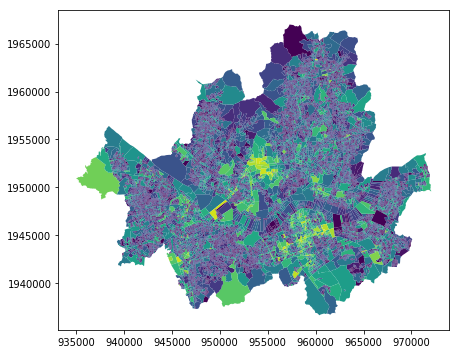

In [21]:
df_map.plot(column='topic_0', figsize=(7,7))

## Generate datasets for web mapping application


### Geojson

In [137]:
# chagne crs to epsg:4326
df_map_wgs = df_map.to_crs({'init': 'epsg:4326'})

# export geopandas dataframe to geojson
geojson = "../data/processed/census-topic.geojson"
if os.path.exists(geojson):
    os.remove(geojson)
df_map_wgs.to_file(geojson, driver="GeoJSON")

### max value table for web app

In [140]:
df_map_wgs.max(axis=0).to_json()

'{"ADM_NM":"\\ud751\\uc11d\\ub3d9","topic_0":0.9718522162,"topic_1":0.9866239885,"topic_2":0.951059973,"topic_3":0.8887156619,"topic_4":0.8163271901,"topic_5":0.9724691302,"topic_6":0.463504019,"topic_7":0.7101315165,"topic_8":0.8556915534,"topic_9":0.6162096342,"topic_10":0.9179109952,"topic_11":0.875136506,"topic_12":0.981917131,"topic_13":0.5738386082,"topic_14":0.7383929433,"census":"1125074033301"}'

### vector tiles

- Create mbtiles using tippecanoe and 
- unzip tiles with mb-util. 
- Then upload the tiles to S3.

```
cd ../data/processed
tippecanoe -o census-topic.mbtiles -Z9 -z14 -S12 -ab -pk -pC  census-topic.geojson -f
mb-util census-topic.mbtiles tile --image_format=pbf
aws s3 sync tile s3://seoul-topics/tile
```

### Web Application
https://s3.amazonaws.com/seoul-topics/www/index.html